<a href="https://colab.research.google.com/github/Sanford-Lab/satellite_cnns/blob/main/1-ls_apachae_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Adapted code from the updated cloud tensorflow notebook (linked below). Currently supports the creation of a .tfrecord file with stratified sampling from points in villages and points outside of villages using an apache beam pipeline that runs locally. For larger datasets, the tutorial recommends using a distributed runner. The tutorial uses Dataflow, but the code does not run in the tutorial so perhaps there are issues that need to be worked out by the google or dataflow developers. Some error while trying to read in the tfrecord files locally persist and inhibit further progress at the moment.

Current TODOs: 

* Periodically check the tutorial to see if there are any changes to the Dataflow code.
* Resolve the file read process and training. 
* Train a model using the pipeline (should be quick once the above parts are working)
* Make the code general to take in any country/geometry, land cover classifications, etc. 

https://colab.research.google.com/github/GoogleCloudPlatform/python-docs-samples/blob/main/people-and-planet-ai/land-cover-classification/cloud-tensorflow.ipynb#scrollTo=D8Kwmqa8CpQV

## Setup

In [ ]:
repo_url = "https://raw.githubusercontent.com/GoogleCloudPlatform/python-docs-samples/main/people-and-planet-ai/land-cover-classification"

!wget --quiet {repo_url}/requirements.txt

In [ ]:
!pip install --quiet --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.5 MB/s eta 0:00:00


In [ ]:
# Install the dependencies.
!pip install --quiet -r requirements.txt

# Restart the runtime by ending the process.
exit()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.8/245.8 kB 18.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.5/515.5 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 20.2 MB/s eta 0:0

At this point restart the runtime

In [ ]:
from __future__ import annotations

import os
from google.colab import auth

auth.authenticate_user()

# Please fill in these values.
project = "ls-test-3-24" #@param {type:"string"}
bucket = "example-bucket-ls-3-24" #@param {type:"string"}
location = "us-central1" #@param {type:"string"}

# Quick input validations.
assert project, "⚠️ Please provide a Google Cloud project ID"
assert bucket, "⚠️ Please provide a Cloud Storage bucket name"
assert not bucket.startswith('gs://'), f"⚠️ Please remove the gs:// prefix from the bucket name: {bucket}"
assert location, "⚠️ Please provide a Google Cloud location"

# Set GOOGLE_CLOUD_PROJECT for google.auth.default().
os.environ['GOOGLE_CLOUD_PROJECT'] = project

# Set the gcloud project for other gcloud commands.
!gcloud config set project {project}

Updated property [core/project].


In [ ]:
# Now let's get the code from GitHub and navigate to the sample.
!git clone https://github.com/GoogleCloudPlatform/python-docs-samples.git
%cd python-docs-samples/people-and-planet-ai/land-cover-classification

Cloning into 'python-docs-samples'...
remote: Enumerating objects: 91454, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 91454 (delta 26), reused 50 (delta 14), pack-reused 91375
Receiving objects: 100% (91454/91454), 197.55 MiB | 24.00 MiB/s, done.
Resolving deltas: 100% (54932/54932), done.
/content/python-docs-samples/people-and-planet-ai/land-cover-classification


In [ ]:
import ee
import google.auth

credentials, _ = google.auth.default()
ee.Initialize(
    credentials.with_quota_project(None),
    project=project,
    opt_url="https://earthengine-highvolume.googleapis.com",
)

In [ ]:
# # Tensorflow setup.
# import tensorflow as tf
# print(tf.__version__)
# # Folium setup.
# import folium
# print(folium.__version__)
# import numpy as np

2.10.0
0.13.0


## Define functions for dataset creation

In [ ]:
def mask_clouds_landsat(image: ee.Image) -> ee.Image:
  # Bits 3 and 5 are cloud shadow and cloud, respectively
  cloudShadowBitMask = (1 << 3) # 1000 in base 2
  cloudsBitMask = (1 << 5) # 100000 in base 2

  # Get the pixel QA band
  qa = image.select('pixel_qa')

  #Both flags should be set to zero, indicating clear conditions
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).bitwiseAnd(qa.bitwiseAnd(cloudsBitMask).eq(0))

  # Mask image with clouds and shadows
  return image.updateMask(mask)

In [ ]:
def get_input_image(year: int, default_value: float = 1000.0) -> ee.Image:
  return(
      ee.ImageCollection("LANDSAT/LE07/C01/T1_SR")
      .filterDate(f'{year}-01-01', f'{year}-12-31')
      .map(mask_clouds_landsat)
      .select("B.*")
      .median()
      .unmask(default_value)
      .float()
  )

In [ ]:
opticalBands = ['B3','B2','B1'] #RGB
thermalBands = ['B4','B3'] #NIR

# Specify inputs (Landsat bands) to the model and the response variable.

BANDS = ['R', 'G', 'B', 'NDVI']
RESPONSE = 'target'

# no more clean code... 
def cloudMaskL457(image): 
  qa = image.select('pixel_qa')
  # If the cloud bit (5) is set and the cloud confidence (7) is high
  # or the cloud shadow bit is set (3), then it's a bad pixel.
  cloud = qa.bitwiseAnd(1 << 5).And(qa.bitwiseAnd(1 << 7)).Or(qa.bitwiseAnd(1 << 3))
  # Remove edge pixels that don't occur in all bands
  mask2 = image.mask().reduce(ee.Reducer.min())
  return image.updateMask(cloud.Not()).updateMask(mask2)

#Import Voronoi Raster here:
voronoi = ee.FeatureCollection('projects/ls-test-3-24/assets/voronoi_villages')

treated_voronoi = voronoi.filter(ee.Filter.eq('treated', 1))

#Get Benin Feature collection
benin = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017").filter(ee.Filter.eq('country_na','Benin')).set('ORIG_FID',0)
treated_voronoi_rast = treated_voronoi.filter(ee.Filter.notNull(['VID'])).reduceToImage(properties=['VID'],reducer= ee.Reducer.first())

# Create a village mask based on the treated village raster
villagemask = treated_voronoi_rast.mask() #select(['ORIG_FID']).gt(.1)

image = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR").filterDate('2007-01-01', '2008-12-31')
image = (image.map(cloudMaskL457).median().clip(benin.geometry().buffer(10000)))
image_ndvi = image.normalizedDifference(thermalBands).rename(['NDVI'])
image_rgb = image.select(opticalBands).rename(['R','G','B']) 
image = image_rgb.addBands(image_ndvi)
image = image.unmask(0)

#Code to add in bands for propensity score prediction 
l7Masked = image.updateMask(villagemask)
l7Unmasked = l7Masked.unmask(-9999)
outside_circle = 'b("R") > -9000'
target = l7Unmasked.expression(outside_circle).rename("target")



In [ ]:
from typing import Iterable

# seed: int, region = region: ee.Geometry, image = image: ee.Image, 
#    points_per_class = points_per_class: int, scale = scale: int
def sample_points(
    seed: int, region = None, image = None, points_per_class = None, scale = None
) -> Iterable[tuple[float, float]]:
    points = image.stratifiedSample(
        points_per_class,
        region=region,
        scale=scale,
        seed=seed,
        geometries=True,
    )
    for point in points.toList(points.size()).getInfo():
        yield point["geometry"]["coordinates"]

# Oversimplified North America region.
region = benin.geometry()
labels_image = target
for point in sample_points(0, region, labels_image, points_per_class=2, scale=1000):
  print(point)

[2.474858607749282, 12.03293323078099]
[1.899936825912788, 7.325761141994698]
[2.241296633878206, 11.197500016549837]
[2.5826564418436244, 6.948468722664499]


In [ ]:
import io
import numpy as np
import requests
from google.api_core import exceptions, retry

@retry.Retry(deadline=10 * 60)  # seconds
def get_patch(image: ee.Image, lonlat: tuple[float, float], patch_size: int, scale: int) -> np.ndarray:
    point = ee.Geometry.Point(lonlat)
    url = image.getDownloadURL({
        "region": point.buffer(scale * patch_size / 2, 1).bounds(1),
        "dimensions": [patch_size, patch_size],
        "format": "NPY",
    })

    # If we get "429: Too Many Requests" errors, it's safe to retry the request.
    # The Retry library only works with `google.api_core` exceptions.
    response = requests.get(url)
    if response.status_code == 429:
        raise exceptions.TooManyRequests(response.text)

    # Still raise any other exceptions to make sure we got valid data.
    response.raise_for_status()
    return np.load(io.BytesIO(response.content), allow_pickle=True)

In [ ]:
from numpy.lib.recfunctions import structured_to_unstructured

def get_input_patch(image, year: int, lonlat: tuple[float, float], patch_size: int) -> np.ndarray:
    patch = get_patch(image, lonlat, patch_size, scale=30)
    return structured_to_unstructured(patch)

def get_label_patch(image, lonlat: tuple[float, float], patch_size: int) -> np.ndarray:

    patch = get_patch(image, lonlat, patch_size, scale=30)
    return structured_to_unstructured(patch)

## Small test/visualization

In [ ]:
# def get_training_example(image, labels, lonlat: tuple[float, float], patch_size: int = 128) -> tuple[np.ndarray, np.ndarray]:
#     return (
#         get_input_patch(image, 2020, lonlat, patch_size),
#         get_label_patch(labels, lonlat, patch_size),
#     )

# this version of get_training_example works with the apache pipeline
def get_training_example(lonlat, image = None, labels = None, patch_size = 128):
    return (
        get_input_patch(image, 2020, lonlat, patch_size),
        get_label_patch(labels, lonlat, patch_size),
    )
point = (2.474858607749282,12.03293323078099)
#point = (2.4, 9.8)  # (lon, lat)
(inputs, labels) = get_training_example(point, image = image, labels = target, patch_size = 128)
print(f"inputs : {inputs.dtype} {inputs.shape}")
print(f"labels : {labels.dtype} {labels.shape}")

## is the longitude and latitude reversed??!?!?!?!?!?!?!?

inputs : float64 (128, 128, 4)
labels : uint8 (128, 128, 1)


In [ ]:
np.amax(inputs)

2252.0

In [ ]:
inputs.shape

(128, 128, 4)

In [ ]:
inputs_visual = inputs[:,:, :3]
inputs_visual = inputs_visual/np.amax(inputs_visual)

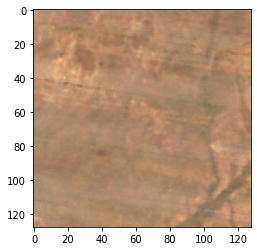

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(inputs_visual)

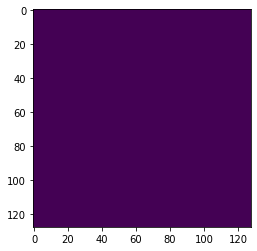

In [ ]:
plt.imshow(labels)
plt.show()

In [ ]:
#Visualize imagery
import folium
mapid = target.getMapId({'min': 0, 'max': 1})
map = folium.Map(location=[9.8, 2.4], zoom_start = 7)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='target variable',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [ ]:
image.info()

In [ ]:
import folium

vis_params = {
  "min": 0,
  "max": 3000,
  "bands": ["R", "G", "B"],
}
folium.Map(
    location=(9.8, 2.4),
    zoom_start=7,
    tiles=image.getMapId(vis_params)["tile_fetcher"].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
)

## Serialize data and create pipeline

In [ ]:
from create_dataset import serialize_tensorflow
inputs = inputs_visual
serialized = serialize_tensorflow(inputs, labels)
print(f"serialized: {len(serialized)} bytes")

serialized: 409696 bytes


This is a helpful resource for understanding and using Apache beam: https://beam.apache.org/get-started/tour-of-beam/

The code below runs locally, and takes approximately 1.5 mins to run

In [ ]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
# note to self: sample_points in the example takes 
#def sample_points(seed: int, polygons: list[list[tuple[float, float]]], 
#points_per_class: int, scale: int=1000) ->Iterable[tuple[float, float]]
with beam.Pipeline() as pipeline:
    (
        pipeline
        | "🌱 Make seeds" >> beam.Create([0])
        | "🛰 Sample points" >> beam.FlatMap(sample_points, region = region, image = labels_image, points_per_class = 2, scale = 1000)
        | "📖 Get examples" >> beam.Map(get_training_example, image = image, labels = target, patch_size = 128)
        | "✍🏽 Serialize" >> beam.MapTuple(serialize_tensorflow)
        | "📚 Write TFRecords" >> beam.io.WriteToTFRecord(
            "data/part", file_name_suffix=".tfrecord.gz"
        )
    )

In [ ]:
# Let's take a look at the dataset files.
!ls -lh data

total 636K
-rw-r--r-- 1 root root 634K Mar 24 17:23 part-00000-of-00001.tfrecord.gz


Next use a distributed runner to run on a larger dataset

In [ ]:
points_per_class = 100

!python create_dataset.py "tensorflow" \
  --data-path="gs://{bucket}/land-cover/data" \
  --points-per-class="{points_per_class}" \
  --runner="DataflowRunner" \
  --project="{project}" \
  --region="{location}" \
  --temp_location="gs://{bucket}/land-cover/temp/benin"

INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "int"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "list[list[tuple[float, float]]]"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "int"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "int"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "Iterable[tuple[float, float]]"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "int"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "list[list[tuple[float, float]]]"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "int"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to An

There is some error with the Dataflow pipeline. The original tutorial also does not work, so I do not believe that this is an error on our end. 

LS: should work now, I think it's a permissions issue with the cloud project

## Read data and train model


In [ ]:
!pwd

/content/python-docs-samples/people-and-planet-ai/land-cover-classification


In [ ]:
!cd ~

In [ ]:
!cd data
!ls

/bin/bash: line 0: cd: data: No such file or directory
cloud-tensorflow.ipynb	 noxfile_config.py	requirements-test.txt
create_dataset.py	 predict_batch.py	requirements.txt
e2e_test.py		 predict-locations.csv	serving
images			 pretrained-model	setup.py
land-cover-change.ipynb  README.ipynb		trainer
MANIFEST.in		 README.md		visualize.py


Running into error:

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Type mismatch between parsed tensor (double) and dtype (float)
	 [[{{node ParseTensor}}]] [Op:IteratorGetNext]


In [ ]:
from trainer.tf_model import read_dataset

data_path = f"gs://{bucket}/land-cover/data"
dataset = read_dataset(data_path)

for x, y in dataset.take(1):
  print("inputs:", x.dtype.name, x.shape)
  print("labels:", y.dtype.name, y.shape)

inputs: float32 (128, 128, 13)
labels: float32 (128, 128, 9)


In [ ]:
import tensorflow as tf
from trainer.tf_model import create_model, split_dataset

(train_dataset, test_dataset) = split_dataset(dataset)
model = create_model(dataset)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
# Number of times to go through the training dataset.
epochs = 5

# Train the model.
model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

# Save it as files.
model.save("model")

Epoch 1/5
5/5 [==============================] - 195s 33s/step - loss: 2.0863 - one_hot_io_u_1: 0.1172 - val_loss: 1.8768 - val_one_hot_io_u_1: 0.1661
Epoch 2/5
5/5 [==============================] - 137s 28s/step - loss: 1.7655 - one_hot_io_u_1: 0.1955 - val_loss: 1.6627 - val_one_hot_io_u_1: 0.2288
Epoch 3/5
5/5 [==============================] - 136s 27s/step - loss: 1.5594 - one_hot_io_u_1: 0.2295 - val_loss: 1.4927 - val_one_hot_io_u_1: 0.2468
Epoch 4/5
5/5 [==============================] - 136s 27s/step - loss: 1.4437 - one_hot_io_u_1: 0.2481 - val_loss: 1.3854 - val_one_hot_io_u_1: 0.2659
Epoch 5/5
5/5 [==============================] - 136s 27s/step - loss: 1.3648 - one_hot_io_u_1: 0.2738 - val_loss: 1.3204 - val_one_hot_io_u_1: 0.2921


In [ ]:
!pip install shapely
from google.cloud import aiplatform

epochs = 100

aiplatform.init(project=project, location=location, staging_bucket=bucket)

# https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.CustomTrainingJob
job = aiplatform.CustomTrainingJob(
    display_name=f"land-cover",
    script_path="trainer/tf_model.py",
    container_uri="us-docker.pkg.dev/vertex-ai/training/tf-gpu.2-9:latest",
)

job.run(
    machine_type='n1-highmem-8',
    accelerator_type='NVIDIA_TESLA_T4',
    accelerator_count=1,
    args=[
        f"--data-path=/gcs/{bucket}/land-cover/data",
        f"--model-path=/gcs/{bucket}/land-cover/model-large",
        f"--epochs={epochs}",
    ],
)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


ImportError: ignored

## ☁️ Cloud Run predictions

[Cloud Run](https://cloud.google.com/run) allows us to deploy
[_serverless_](https://en.wikipedia.org/wiki/Serverless_computing)
web services with a
[REST API](https://en.wikipedia.org/wiki/Representational_state_transfer).
Cloud Run autoscales from zero workers when there are no requests, to enough workers to handle high traffic of requests.
It's a great and efficient option to host a predictions server without having to have servers up and running all the time.

Cloud Run autoscales from zero workers when there are no requests, to enough workers to handle high traffic of requests.
It's a great and efficient option to host a predictions server without having to have servers up and running all the time.

We deploy our service to Cloud Run
[directly from source code](https://cloud.google.com/run/docs/deploying-source-code)
so we don't need to build the container image first.
Behind the scenes, this command uses Google Cloud [Buildpacks](https://buildpacks.io/) and
[Cloud Build](https://cloud.google.com/build)
to automatically build a container image from our source code in the [`serving`](serving) directory.

TensorFlow can use a lot of memory, so we increase the
[memory limit](https://cloud.google.com/run/docs/configuring/memory-limits)
for our service to 1GB.
We also want to define a default model to use by passing an
[environment variable](https://cloud.google.com/run/docs/configuring/environment-variables)
to our container image.
We can override the model path via the `model-path`
[URL query parameter](https://en.wikipedia.org/wiki/Query_string).
For Cloud Run to access the model, it _must_ be in Cloud Storage.

> <button>
>
> [![Open in GitHub](https://www.tensorflow.org/images/GitHub-Mark-32px.png) `serving/main.py`](serving/main.py)
> </button>

In [ ]:
service_name = "land-cover"
model_path = f"gs://{bucket}/land-cover/model"

!gcloud run deploy {service_name} \
  --source="serving/" \
  --region="{location}" \
  --update-env-vars="MODEL_PATH={model_path}" \
  --memory="1G" \
  --no-allow-unauthenticated

API [artifactregistry.googleapis.com] not enabled on project [978289642310]. 
Would you like to enable and retry (this will take a few minutes)? (y/N)?  y

Enabling service [artifactregistry.googleapis.com] on project [978289642310]...
Operation "operations/acat.p2-978289642310-91bf02ea-2fcc-4ea3-937a-ccb1b3df4e9c" finished successfully.
Deploying from source requires an Artifact Registry Docker repository to store 
built containers. A repository named [cloud-run-source-deploy] in region 
[us-central1] will be created.

Do you want to continue (Y/n)?  y

This command is equivalent to running `gcloud builds submit --pack image=[IMAGE] serving/` and `gcloud run deploy land-cover --image [IMAGE]`

Building using Buildpacks and deploying container to Cloud Run service [land-cover] in project [ls-test-3-24] region [us-central1]
API [cloudbuild.googleapis.com] not enabled on project [978289642310]. Would you
 like to enable and retry (this will take a few minutes)? (y/N)?  y

Enabling servic

> 💡 Look at your Cloud Run services: https://console.cloud.google.com/run

When the Cloud Run service is deployed, you'll see some information including the Service URL.

We can also get the URL from the Cloud Console, or with [`gcloud run services describe`](https://cloud.google.com/sdk/gcloud/reference/run/services/describe).


In [ ]:
import subprocess

cmd = ["gcloud", "run", "services", "describe", service_name, f"--region={location}", "--format=get(status.url)"]
model_url = subprocess.run(cmd, check=True, stdout=subprocess.PIPE).stdout.decode('utf-8').strip()
print(f"model_url: {model_url}")

Since we only accept authorized calls in our web service, we also need to authenticate each call.

Colab notebooks aren't tied to a Service Account, so we can't get the identity token here.

Run this command in your **local terminal** or in [**Cloud Shell**](https://shell.cloud.google.com/?show=terminal), and then copy-paste your **🔑 Identity token** from the output of the command into the following variable and run that cell.

```sh
# Run in a terminal and copy-paste the outputs.
gcloud auth print-identity-token
```

In [ ]:
identity_token = "" #@param {type:"string"}

> 💡 Your identity token changes over time, so you might need to generate a new one if you're getting authentication errors.

> 💡 To learn more on how to authenticate to Cloud Run, see the
> [Authentication overview](https://cloud.google.com/run/docs/authenticating/overview) page.

Now let's get some predictions from our Cloud Run service.
The service first gets the input data from Earth Engine, gets the predictions and returns them as JSON.

In [ ]:
import numpy as np
import requests

response = requests.get(
    f"{model_url}/predict/-121.526/39.781/2018",
    headers={"Authorization": f"Bearer {identity_token}"},
    params={"patch-size": 512},
)

response.raise_for_status()
results = response.json()

predictions = np.array(results['predictions'], np.uint8)
print(f"predictions : {predictions.dtype.name} {predictions.shape}")

In [ ]:
from visualize import show_outputs

show_outputs(predictions[:, :, None])

> 💡 We return the prediction results as plain JSON since it's simple and human-readable.
> If you're expecting large outputs, it might be a good idea to serialize and compress the predictions response before sending them, but the receiving end would have to decompress and deserialize the results back.
> You could also write large results to a Cloud Storage location.